In [1]:
%matplotlib inline 
import scipy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import PyDSTool as dst
import copy
from tqdm import tqdm


\begin{equation}
\frac{dR_E}{dt} = \frac{a_1B_{M}(T_I+k_1P)}{(\gamma_1+B_M)(1+\alpha_{RE}I_E)} - \mu_{RE}R_E 
\end{equation}

\begin{equation}
\frac{dB_{M,i}}{dt} = k_{dif}(\frac{B_{FBA,i}}{V_{FBA}}-\frac{B_{M,i}}{V_{M}})-\frac{k_{AD}B_{M,i}}{k_3 +\sum\limits_{j=1}^n B_{M,j}}  - \frac{k_{AT}R_EB_{M,i}}{\alpha_{EM}+R_E}E - \epsilon B_{M,i}
\end{equation}

\begin{equation}
k_{dif} = \frac{k_{max}\gamma_{dif}}{\gamma_{dif}+[MUC2]}
\end{equation}

\begin{equation}
[MUC2]= E(\delta_{muc} + \frac{[SCFA](1-\delta_{muc})}{[SCFA]+\alpha_{muc}})
\end{equation}

\begin{equation}
\epsilon = \epsilon_o+\epsilon_E(E_{max}-E)
\end{equation}
 
\begin{equation}
\frac{dE}{dt} = \mu_E \frac{E}{E+\gamma_E}-(d_1+d_2[P-\frac{V_{S1}[SCFA]}{[SCFA]+\gamma_{S1}-T_{EP}]_+)E
\end{equation}


\begin{equation}
\frac{dI_E}{dt} = \frac{k_{IE}R_E}{\gamma_{IE}+R_E} - \alpha_{11}B_M - \mu_{IE}IE
\end{equation}

\begin{equation}
\frac{dB}{dt} = [\epsilon B_{M} - T]_{+} - k_{5}PB + \mu_BB
\end{equation}

\begin{equation}
\frac{dP}{dt} = \frac{k_{PM}B}{\gamma_{12}+B}(0.5+\frac{P}{P+1})(1-\frac{V_{S2}[SCFA]}{[SCFA]+\gamma_{S2}}) + \frac{k_{PE}[R_E-T_{RE}]_+E}{1+\gamma_{PE}I_E} - \mu_4P
\end{equation}



In [44]:
# variable_dict = {
#     'B_M':'B_MSource - (k_AD*B_M)/(k_3+B_M) - (k_AT*R_E*B_M)/(alpha_EM+R_E)-epsilon*B_M',
#     'epsilon':'(epsilon_0-epsilon)/tau_p + f*P*(epsilon_max-epsilon)',
#     'R_E': '(a_1*B_M*(k_1*P+T_I))/((gamma_1+B_M)*(1+alpha_RE*I_E))-mu_RE*R_E',
#     'I_E': '(k_IE*R_E)/(gamma_IE+R_E)+alpha_11*B_M-mu_IE*I_E',
#     'B':'max(0,epsilon*B_M-T) -k_5*P*B',
#     'P':'(k_PM*B)/(gamma_12+B)+(k_PE*max(0,R_E-T_RE))/(1+gamma_PE*I_E)-mu_4*P',
#     'Ep': 'mu_E*(Ep/(Ep+gamma_E))-(d1+d2*P)*Ep'
    
# }
#(1-V_S2*S/(S+gamma_s2))
#(k_max*gamma_dif/(gamma_dif+E*(delta_muc+S*(1-delta_muc)/(S+alpha_muc))))

variable_dict = {
    'B_L': 'B_MSource - (k_max*gamma_dif^n1/(gamma_dif^n1+(E*(delta_muc+S*(1-delta_muc)/(S+alpha_muc)))^n1))*(B_L/V_L - B_M/V_M) - d_BL*B_L',
    'B_M':'(k_max*gamma_dif^n1/(gamma_dif^n1+(E*(delta_muc+S*(1-delta_muc)/(S+alpha_muc)))^n1))*(B_L/V_L-B_M/V_M) - (k_AD*B_M)/(k_3+B_M) - (k_AT*R_E*B_M)*Ep/(alpha_EM+R_E)-(epsilon_0+epsilon_E*(E_max-E)^ne/((E_max-E)^ne+k_epsilon^ne))*B_M',
    'R_E': '(a_1*B_M*(k_1*P+T_I))/((gamma_1+B_M)*(1+alpha_RE*I_E))-mu_RE*R_E',
    'I_E': '(k_IE*R_E)/(gamma_IE+R_E)+alpha_11*B_M-mu_IE*I_E',
    'B':'max(0, ((epsilon_0+epsilon_E*(E_max-E)^ne/((E_max-E)^ne+k_epsilon^ne))*B_M-T)) -k_5*P*B + mu_B*B',
    'P':'((k_PM*B)/(gamma_12+B))*(delta_Po+delta_PI*P^np/(P^np+gamma_PI^np))*(1-V_S2*S/(S+gamma_s2))+(k_PE*max(0,R_E-T_RE))*E/(1+gamma_PE*I_E)-mu_4*P',
    'Ep': 'mu_E*(Ep/(Ep+gamma_E))-(d1+d2*max(0,P-V_S1*S/(S+gamma_s1)-T_EP))*Ep'
    
}


d1= 0.125/4
gamma_E=0.5
mu_E=0.5/4
E_max = (mu_E-gamma_E*d1)/d1
parameter_dict = {
    'V_L': 1,
    'V_M':0.5,
    'd_BL':0.5,
    'k_dif': 5,
    'B_MSource':3e6, #1.5e6,#
    'k_AD':1.5e6,#
    'k_3':6e6,
    'k_AT':0.015,
    'alpha_EM':0.18,
    'epsilon_0':0.1,
    'epsilon_max':0.21,
    'tau_p':24,
    'f':0.5,
    'a_1':0.5,#
    'gamma_1':5e6,
    'k_1':1,
    'alpha_RE':2,
    'mu_RE':0.1,
    'k_IE':19,#
    'gamma_IE':10,
    'alpha_11':0.1e-7,
    'mu_IE':1,
    'T':1.1e6,
    'k_5':5,
    'k_PM':0.05,
    'gamma_12':1.2e5,
    'k_PE':0.001,
    'T_RE':0.65,
    'gamma_PE':1,
    'mu_4':0.05,
    'T_I':1, 
    'mu_E': mu_E,
    'gamma_E':gamma_E,
    'd1': d1,
    'd2': 0.625/10,
    'E_max': E_max,
    'epsilon_E': 0.1,
    'mu_B':0.05,
    'V_S1' : 0.05,
    'T_EP' : 0.05,
    'gamma_s1' : 1,
    'V_S2' : 0.4,
    'gamma_s2' : 1,
    'delta_muc': 0.5,
    'alpha_muc': 1,
    'k_max': 8,
    'gamma_dif': 1,
    'S' : 0,
    'n1': 3,
    'ne' : 2,
    'np': 2,
    'k_epsilon' : 1,
    'delta_PI' : 1.5,
    'delta_Po' : 0.5,
    'gamma_PI' :0.45
}
#notebook
initial_conditions = {
    'B_L':1e6,
    'B_M':0,
#     'epsilon':0.1,
    'R_E':0,
    'I_E':0,
    'B':0,
    'P':0,
    'Ep':3.5
}

ModelDefinition=dst.args(name="2013 Aciero Model",
                        varspecs=variable_dict,
                        pars=parameter_dict,
                        ics=initial_conditions,
                        tdata=[0,300])
ModelDS = dst.Vode_ODEsystem(ModelDefinition)


In [ ]:
plt.figure(figsize=(10,8))
paramofInterest = 'B_MSource'
SearchP = np.linspace(8e6,1.4e7,10)
AllPoints = []
for p in range(0, len(SearchP)):
    param=SearchP[p]
    ModelDS.set(ics=initial_conditions, pars={paramofInterest:param,'S':0},
                tdata=[0,200])
    P = ModelDS.compute('bbtest').sample()
#     for key in initial_conditions.key:
#         initial_conditions[key] = P[key][-1]
    ics = {k:P[k][-1] for k in P.keys() if k != 't'}
    ModelDS.set(ics=ics,pars={'S':10},
                tdata=[200,600])
    P2 = ModelDS.compute('bbtest').sample()
    A = {}
    for key in P.keys():
        A[key] = list(P[key]) + list(P2[key])
    A['t'] = list(P['t']) + list(P2['t'])


    AllPoints.append(A)

column=0
row=0
column=0
row=1
column=0
row=2
column=0
row=3
column=1
row=0
column=1
row=1
column=1
row=2
column=1
row=3


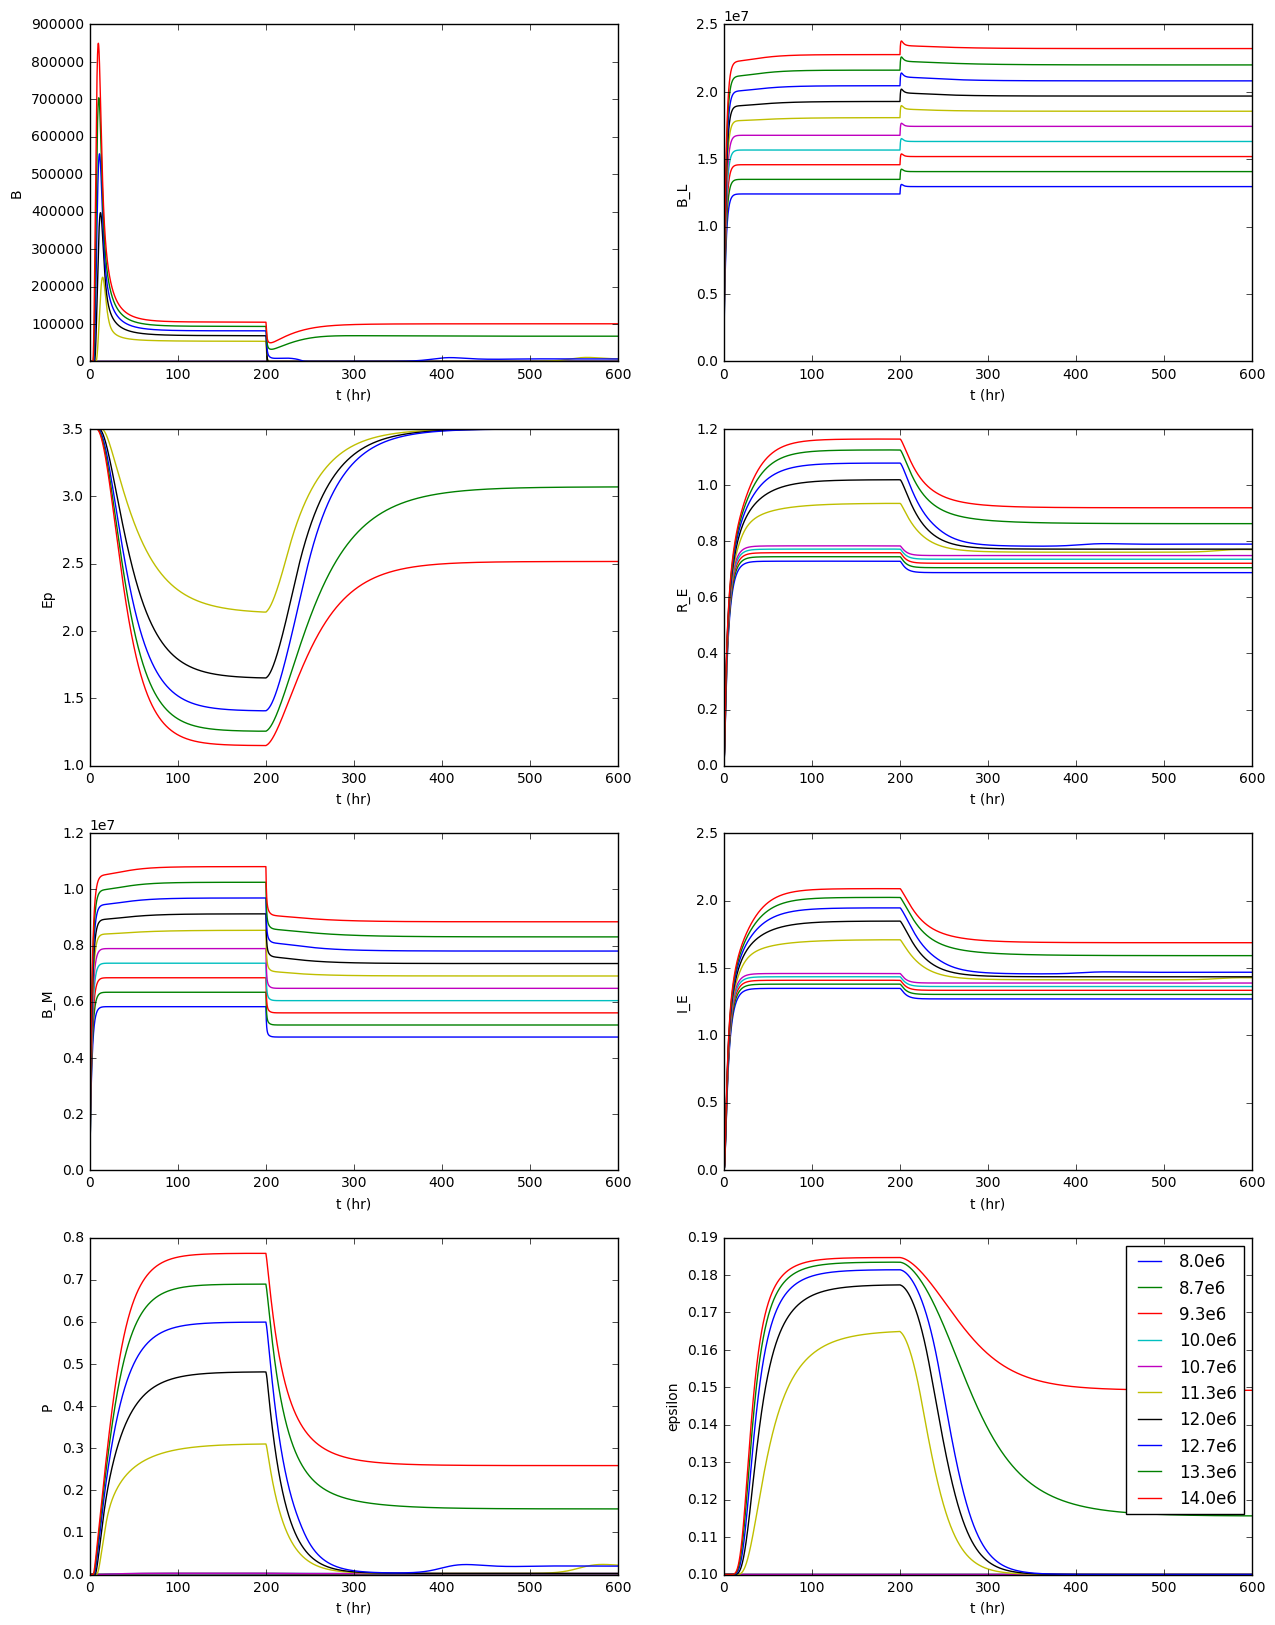

In [87]:
f,ax = plt.subplots(4,2,figsize=(15, 20))
#f.figsize=(200,10)

i = 0
Variables_1 = ['B', 'Ep', 'B_M', 'P']
Variables_2 = ['B_L', 'R_E', 'I_E']
AllVars= ['B', 'Ep', 'B_M', 'P', 'B_L', 'R_E', 'I_E','epsilon']
for index in range(0,len(AllVars)):
    #column= index%2
    row= index%4
    if index <=3:
        column=0
    else:
        column=1
    print('column=' + str(column))
    print('row=' + str(row))
    for p in range(0, len(SearchP)):
        #ax[row][column].set_title(AllVars[index])
        ax[row][column].set_ylabel(AllVars[index]) 
        ax[row][column].set_xlabel('t (hr)')    
        if AllVars[index] != 'epsilon': 
            ax[row][column].plot(AllPoints[p]['t'], AllPoints[p][AllVars[index]], label=str(p/1e6) + 'e6' )
#             if AllVars[index] == 'B':
#                 ax[row][column].set_yscale('log')   
        else:
            A=[epsilon_0+epsilon_E*(E_max-b)**ne/((E_max-b)**ne+k_epsilon**ne) for b in AllPoints[p]['Ep']]
            ax[row][column].plot(AllPoints[p]['t'], A, label=str(round(SearchP[p]/1e6,1)) + 'e6')
            ax[row][column].legend()    

        
plt.savefig('./immune_result.pdf', bbox_inches='tight')
#ax[1][3].legend()
    
# for var in variable_dict.keys():
#     plt.figure(figsize=(10,8))
#     for p in range(0, len(SearchP)):
#         ax[1][i].plot(AllPoints[p]['t'], AllPoints[p][var], label=p)
#     plt.xlabel('t')
#     plt.ylabel(var)
#     plt.legend(SearchP)
#     plt.show()
# for var in Variables_1:
#     #plt.figure(figsize=(10,8))
#     for p in range(0, len(SearchP)):
#         ax1[i].plot(AllPoints[p]['t'], AllPoints[p][var], label=p)
#     ax1[i].set_xlabel('t')
#     ax1[i].set_ylabel(var)
#     #ax1[i].legend(SearchP)
#     i += 1
#     #ax.show()
# i=0
# for var in Variables_2:
#     #plt.figure(figsize=(10,8))
#     for p in range(0, len(SearchP)):
#         ax2[i].plot(AllPoints[p]['t'], AllPoints[p][var], label=p)
#     ax2[i].set_xlabel('t')
#     ax2[i].set_ylabel(var)
#     #ax2[i].legend(SearchP)
#     i+=1
# ax2[i].legend()

# # plt.plot(P['t'], P['epsilon'], label=p)

# # plt.xlabel('t')
# # plt.ylabel('epsilon')
# # plt.legend()
# # plt.ylim([0.08,0.22])
# # plt.show()


# plt.figure(figsize=(10,8))
# ne = parameter_dict['ne']
# epsilon_0 = parameter_dict['epsilon_0']
# epsilon_E= parameter_dict['epsilon_E']
# E_max = parameter_dict['E_max']
# k_epsilon = parameter_dict['k_epsilon']
# for p in range(0, len(SearchP)):
#     A=[epsilon_0+epsilon_E*(E_max-b)**ne/((E_max-b)**ne+k_epsilon**ne) for b in AllPoints[p]['Ep']]
#     plt.plot(AllPoints[p]['t'], A, label=p)
# plt.xlabel('t')
# plt.ylabel('epsilon')
# plt.legend(SearchP)
#plt.show()




In [ ]:
ModelDS.set(ics={'P':1.0})
P=ModelDS.compute('test').sample()
plt.plot(P['t'], P['P'])


In [ ]:
def NC(epsilon, B_M):
    B_MSource = 1e6#1.65e6
    k_AD = 1.5e6
    k_3 = 6e6
    alpha_EM = 0.18
    R_E= 0.0
    k_AT = 0.03
    return(B_MSource - (k_AD*B_M)/(k_3+B_M) - (k_AT*R_E*B_M)/(alpha_EM+R_E)-epsilon*B_M)
E_VALS = np.arange(0.0,0.25,0.01)
B_VALS = np.arange(0.0,20e6,1e2)
E=[]
B=[]
for eps in tqdm(E_VALS):
    for b in B_VALS:
        if NC(eps,b) < 1e-7:
            E.append(eps)
            B.append(b)
plt.plot(B,E,'k.')
plt.ylim(0.0,0.25)
plt.xlim(0.0,20e6)

In [ ]:
(1.05*0.1-0.5*0.016)*(5+10.6)/10.6


In [ ]:
(0.15*10/((5+10)*0.06)-1)/2

In [ ]:
1.067*10.6/0.6

In [ ]:
(.15*10/(0.03*(15))-1)/2

In [50]:
ModelDefinition.varspecs.keys()

dict_keys(['B', 'Ep', 'B_M', 'P', 'B_L', 'R_E', 'I_E'])